In [ ]:
import tarfile
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import spacy

def load_data(file_path):
    with open(file_path, encoding='utf-8') as file:
        lines = [line.strip().lower() for line in file if line.strip()]
    return lines

# Load English and French data
english_sentences = load_data('europarl-v7.fr-en.en')
french_sentences = load_data('europarl-v7.fr-en.fr')


spacy_embedding_en = spacy.load('en_core_web_md')
spacy_embedding_fr = spacy.load('fr_core_news_md')
# Tokenization and Padding
#tokenizer = Tokenizer()
#tokenizer.fit_on_texts(english_sentences + french_sentences)
#vocab_size = len(tokenizer.word_index) + 1

def preprocess(lang_sentences, percentages, lang_models):
    data = []
    for sentence_0, sentence_1 in zip(*lang_sentences):
        embedded_0 = lang_models[0](sentence_0).vector
        embedded_1 = lang_models[1](sentence_1).vector
        max_len = max(len(embedded_0), len(embedded_1))
        pad_embedded_0 = np.pad(embedded_0, (0, max_len - len(embedded_0)), 'constant')
        pad_embedded_1 = np.pad(embedded_1, (0, max_len - len(embedded_1)), 'constant')
        random_mat = np.random.rand(*embedded_0.shape)
        full = pad_embedded_0 * percentages[0] + pad_embedded_1 * percentages[1] + random_mat
        data.append(full)
    return np.array(data)

mashed_sentences = preprocess([english_sentences, french_sentences],
                          [0.5, 0.5],
                          [spacy_embedding_en, spacy_embedding_fr])

print(english_sentences[0])
print(french_sentences[0])
print(mashed_sentences[0])

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_dim=latent_dim),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(50, activation='softmax')  # Output length as max sentence length
    ])
    return model

def build_discriminator(sentence_length):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(sentence_length,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [ ]:
import matplotlib.pyplot as plt

discriminator_loss = []
generator_loss = []

class GAN:
    def __init__(self, latent_dim, sentence_length):
        self.generator = build_generator(latent_dim)
        self.discriminator = build_discriminator(sentence_length)
        self.discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        self.combined = tf.keras.models.Model(self.generator.input, self.discriminator(self.generator.output))
        self.combined.compile(optimizer='adam', loss='binary_crossentropy')

    def train(self, data, epochs, batch_size):
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            idx = np.random.randint(0, data.shape[0], batch_size)
            real_data = data[idx]

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            generated_data = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(real_data, real)
            d_loss_fake = self.discriminator.train_on_batch(generated_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            discriminator_loss.append(d_loss)

            g_loss = self.combined.train_on_batch(noise, real)
            generator_loss.append(g_loss)

            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{epochs} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

latent_dim = 100
gan = GAN(latent_dim, 50)
gan.train(english_data, epochs=1000, batch_size=32)


1/1 [==============================] - 0s 15ms/step
Epoch 100/1000 [D loss: 2.427980661392212, acc.: 50.0] [G loss: 0.017235977575182915]
1/1 [==============================] - 0s 29ms/step
Epoch 200/1000 [D loss: 0.3459985852241516, acc.: 100.0] [G loss: 0.7180488705635071]
1/1 [==============================] - 0s 19ms/step
Epoch 300/1000 [D loss: 0.6472909450531006, acc.: 50.0] [G loss: 0.36351633071899414]
1/1 [==============================] - 0s 17ms/step
Epoch 400/1000 [D loss: 0.7177719473838806, acc.: 50.0] [G loss: 0.3367061913013458]
1/1 [==============================] - 0s 26ms/step
Epoch 500/1000 [D loss: 0.6133091449737549, acc.: 50.0] [G loss: 0.46426188945770264]
1/1 [==============================] - 0s 17ms/step
Epoch 600/1000 [D loss: 0.5504212379455566, acc.: 50.0] [G loss: 0.5941251516342163]
1/1 [==============================] - 0s 31ms/step
Epoch 700/1000 [D loss: 0.3202908933162689, acc.: 100.0] [G loss: 0.7495474219322205]
1/1 [==============================]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


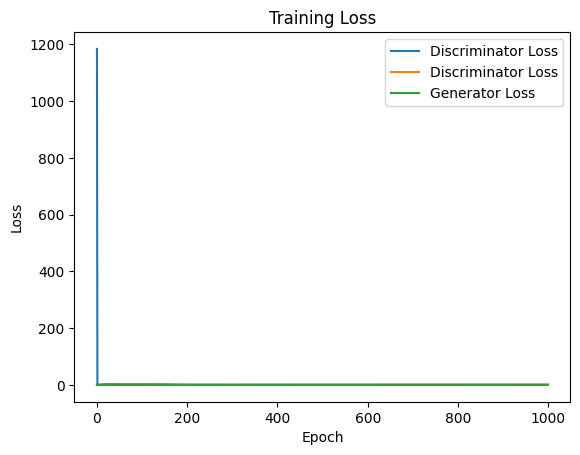

In [ ]:
# Save the model
gan.generator.save('generator_model.h5')
gan.discriminator.save('discriminator_model.h5')

# Plotting the training progress (you need to modify the training loop to store loss values)
plt.plot(discriminator_loss, label='Discriminator Loss')
plt.plot(generator_loss, label='Generator Loss')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
def generate_text(generator, tokenizer, latent_dim, num_sentences):
    # Generate noise.
    noise = np.random.normal(0, 1, (num_sentences, latent_dim))
    # Generate token indices from the noise using the generator.
    generated_sequences = generator.predict(noise)
    # Convert the output probabilities to token indices.
    generated_sequences = np.argmax(generated_sequences, axis=-1)

    # Initialize an empty list to hold the generated sentences.
    text_batch = []

    # Process each sequence to convert token indices to words.
    for seq in generated_sequences:
        # Filter out zeros (unwanted tokens) from the sequence.
        filtered_indices = seq[seq != 0]
        # Convert non-zero indices to words using the tokenizer.
        words = [tokenizer.index_word.get(i, '') for i in filtered_indices]
        # Join the words to form a sentence.
        sentence = ' '.join(words).strip()
        # Add the sentence to the batch of generated text.
        text_batch.append(sentence)

    return text_batch

# Example usage of the function to generate text.
generated_text = generate_text(gan.generator, tokenizer, latent_dim=100, num_sentences=15)
for text in generated_text:
    print(text)


1/1 [==============================] - 0s 19ms/step
nous
nous
nous
nous
nous
nous
nous
nous
nous
nous
nous
nous
nous
nous
nous
